# Merging Parks Data

In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re
from fuzzywuzzy import process
import contextily as ctx
from shapely.geometry import Point

----
&nbsp;
### Extracting the geometric elements from `nps_boundary.geojson`

In [38]:
df = pd.read_csv("DATA/Masters/parks.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (56, 6)


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [39]:
# url = https://catalog.data.gov/dataset/national-park-boundaries/resource/cee04cfe-f439-4a65-91c0-ca2199fa5f93

gdf = gpd.read_file('DATA/nps_boundary.geojson')
print(f"Shape: {gdf.shape}")
gdf.head()

Shape: (510, 10)


,GIS_LOC_ID,UNIT_CODE,GROUP_CODE,UNIT_NAME,UNIT_TYPE,META_MIDF,LANDS_CODE,DATE_EDIT,GIS_NOTES,geometry
0,None,UPDE,None,Upper Delaware,Scenic and Recreational River,None,None,2006-06-06,POC for this update: leslie_morlock@nps.gov -...,"POLYGON ((-74.92112 41.4903, -74.91918 41.4912..."
1,None,BAND,None,Bandelier,National Monument,None,None,None,Park Created Boundary - contact Kay Beeley,"MULTIPOLYGON (((-106.19585 35.85378, -106.2214..."
2,None,ACAD,None,Acadia,National Park,None,None,None,Shift 0.03 mi.,"MULTIPOLYGON (((-68.22595 44.39584, -68.22766 ..."
3,None,ROCR,None,Achbold Parkway,Park,None,None,None,None,"MULTIPOLYGON (((-77.0843 38.91673, -77.08482 3..."
4,None,ADAM,None,Adams,National Historical Park,None,None,None,Shift 0.03 mi.,"POLYGON ((-71.00948 42.25625, -71.01133 42.255..."


#### Need to normalise `Park Code`/`UNIT_CODE` between the DataFrames 

In [40]:
df_filter = df.copy()

# Function to clean park names by removing "National Park", "National Parks", and specific variations
def clean_park_name(name):
    return re.sub(r' National Parks?$| National Park and Preserve$', '', name, flags=re.IGNORECASE).strip()

df_filter['Cleaned_Park_Name'] = df_filter['Park Name'].apply(clean_park_name)

In [41]:
# Create a dictionary to store matches based on cleaned names
name_matches = {}

# Search for each cleaned park name in the GeoJSON
for index, row in df_filter.iterrows():
    park_code = row['Park Code']
    cleaned_name = row['Cleaned_Park_Name']

    # Try to match the cleaned park name in UNIT_NAME of GeoJSON
    matching_rows = gdf[gdf['UNIT_NAME'].str.contains(cleaned_name, case=False, na=False)]

    if not matching_rows.empty:
        matched_name = matching_rows['UNIT_NAME'].values[0]
        matched_code = matching_rows['UNIT_CODE'].values[0]
        name_matches[cleaned_name] = (matched_name, matched_code, park_code) 
    else:
        print(f"No match found for {cleaned_name} in GeoJSON")

# Identify unmatched parks by cleaned name
unmatched_csv = [row['Cleaned_Park_Name'] for _, row in df_filter.iterrows() if row['Cleaned_Park_Name'] not in name_matches]
print(f"\nParks in CSV without a match in GeoJSON: {unmatched_csv}")

No match found for Hawaii Volcanoes in GeoJSON
No match found for Sequoia and Kings Canyon in GeoJSON
No match found for Wrangell - St Elias in GeoJSON

Parks in CSV without a match in GeoJSON: ['Hawaii Volcanoes', 'Sequoia and Kings Canyon', 'Wrangell - St Elias']


In [42]:
# More granular searching for unmatched parks using fuzzy matching
for park_name in unmatched_csv:
    best_match = process.extractOne(park_name, gdf['UNIT_NAME'], scorer=process.fuzz.partial_ratio)
    if best_match and best_match[1] > 80:  
        matched_name = best_match[0]
        matched_code = gdf.loc[gdf['UNIT_NAME'] == matched_name, 'UNIT_CODE'].values[0]
        csv_code = df_filter.loc[df_filter['Cleaned_Park_Name'] == park_name, 'Park Code'].values[0]
        name_matches[park_name] = (matched_name, matched_code, csv_code)
        print(f"Fuzzy matched {park_name} (CSV) with {matched_name} (GeoJSON) - Match score: {best_match[1]}")
    else:
        print(f"No good fuzzy match found for {park_name} in GeoJSON")

Fuzzy matched Hawaii Volcanoes (CSV) with Hawai'i Volcanoes (GeoJSON) - Match score: 94
Fuzzy matched Sequoia and Kings Canyon (CSV) with Kings Canyon (GeoJSON) - Match score: 100
Fuzzy matched Wrangell - St Elias (CSV) with Wrangell-St. Elias (GeoJSON) - Match score: 89


In [43]:
# Create a mapping dictionary of GeoJSON UNIT_CODE to CSV park_code
mapping_dict = {matched_code: csv_code for _, (matched_name, matched_code, csv_code) in name_matches.items()}

# Update GeoJSON with the correct park codes, filtering only for 'National Park'
for matched_code, csv_code in mapping_dict.items():
    gdf.loc[(gdf['UNIT_CODE'] == matched_code) & (gdf['UNIT_TYPE'] == 'National Park'), 'UNIT_CODE'] = csv_code

# Extract the geometry objects for the updated park codes where UNIT_TYPE is 'National Park'
updated_gdf = gdf[(gdf['UNIT_CODE'].isin(mapping_dict.values())) & (gdf['UNIT_TYPE'] == 'National Park')]

In [44]:
print(f"Shape: {updated_gdf.shape}")

Shape: (55, 10)


In [45]:
updated_gdf

,GIS_LOC_ID,UNIT_CODE,GROUP_CODE,UNIT_NAME,UNIT_TYPE,META_MIDF,LANDS_CODE,DATE_EDIT,GIS_NOTES,geometry
2,None,ACAD,None,Acadia,National Park,None,None,None,Shift 0.03 mi.,"MULTIPOLYGON (((-68.22595 44.39584, -68.22766 ..."
29,None,BIBE,None,Big Bend,National Park,None,None,None,Shift 0.03 mi.,"POLYGON ((-102.84985 29.35623, -102.85101 29.3..."
35,None,BISC,None,Biscayne,National Park,None,None,None,Good,"POLYGON ((-80.34638 25.4484, -80.34631 25.4492..."
45,None,CANY,None,Canyonlands,National Park,None,None,None,Shifted 0.04 miles,"MULTIPOLYGON (((-109.88562 38.48543, -109.8853..."
49,None,CARE,None,Capitol Reef,National Park,None,None,None,Shifted 0.04 miles,"POLYGON ((-110.93617 37.7308, -110.93593 37.73..."
64,None,CRLA,None,Crater Lake,National Park,None,None,None,Shifted 0.06 miles,"POLYGON ((-121.96871 42.84353, -121.96898 42.8..."
71,None,DEVA,None,Death Valley,National Park,None,None,None,Shifted 0.05 miles,"MULTIPOLYGON (((-116.98216 37.01698, -116.98 3..."
83,None,EVER,None,Everglades,National Park,None,None,None,Good,"POLYGON ((-80.42132 25.14501, -80.42567 25.142..."
129,None,GRCA,None,Grand Canyon,National Park,None,None,None,Shifted 0.04 miles,"MULTIPOLYGON (((-113.38359 36.18047, -113.3814..."
131,None,GRTE,None,Grand Teton,National Park,None,None,None,Shifted 0.04 miles,"POLYGON ((-110.47268 43.7766, -110.47974 43.77..."


In [46]:
# Extract sets of park codes
park_set_df = set(df_filter["Park Code"])
park_set_gdf = set(updated_gdf['UNIT_CODE'])

# Find mismatches
geo_diff = park_set_df.difference(park_set_gdf)
csv_diff = park_set_gdf.difference(park_set_df)

print(f"Not in GeoParks: {geo_diff}")
print(f"Not in Parks.csv: {csv_diff}")

Not in GeoParks: {'PINN'}
Not in Parks.csv: set()


In [47]:
# Define the keywords to match in the UNIT_NAME column
keywords = ['Pinnacles']
pattern = '|'.join(keywords) 

# Filter the GeoDataFrame for rows where UNIT_NAME contains any of the keywords
# Using case=False for case-insensitivity and na=False to ignore NaN values
matching_gdf = gdf[gdf['UNIT_NAME'].str.contains(pattern, case=False, na=False)]
matching_gdf

,GIS_LOC_ID,UNIT_CODE,GROUP_CODE,UNIT_NAME,UNIT_TYPE,META_MIDF,LANDS_CODE,DATE_EDIT,GIS_NOTES,geometry
223,None,PINN,None,Pinnacles,National Monument,None,None,None,Shifted 0.06 miles,"MULTIPOLYGON (((-121.23966 36.54625, -121.2395..."


In [48]:
geo_df = pd.concat([updated_gdf, matching_gdf])
assert geo_df.shape[0] == 56, "The DataFrame has incorrect dimension"

In [49]:
park_set_df = set(df_filter["Park Code"])
park_set_gdf = set(geo_df['UNIT_CODE'])

try:
    assert park_set_df == park_set_gdf, f"Park codes do not match: Missing in GeoDataFrame: {park_set_df - park_set_gdf}, Extra in GeoDataFrame: {park_set_gdf - park_set_df}"
except AssertionError as e:
    print(e)
    raise
else:
    print("All park codes match correctly between CSV and GeoDataFrame.")

All park codes match correctly between CSV and GeoDataFrame.


In [50]:
geo_df = geo_df[['UNIT_CODE', 'geometry']]

----
&nbsp;
### Cleaning `parks.csv` and merging with geometry data 
on 'Park Code' == 'UNIT_CODE'


In [51]:
print(f"Shape: {df.shape}")
df.head()

Shape: (56, 6)


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


In [52]:
# convert column to lowercase, replace spaces
df.columns = [col.lower().replace(" ", "_") for col in df.columns]

In [53]:
# convert acres to square kilometers
def acres_to_sq_km(acres):
    return round(acres * 0.00404686, 2)

df['square_km'] = df['acres'].apply(acres_to_sq_km)

In [54]:
# Remove all text beyond " National Park" including variations like " and Preserve"
df['park_name'] = df['park_name'].str.replace(r' National Park.*', '', case=False, regex=True)

----
&nbsp;
#### Creating a POINT geometry GeoJSON file `parks_points.geojson`

In [55]:
df_transform = df.copy()

# Create POINT geometry from latitude and longitude
df_transform['geometry'] = df_transform.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

df_transform = df_transform.drop(columns=['acres', 'latitude', 'longitude'])
geo_df_points = gpd.GeoDataFrame(df_transform, geometry='geometry', crs="EPSG:4326")

print(f"Type: {type(geo_df_points)}\nShape: {geo_df_points.shape}")
geo_df_points.head()

Type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (56, 5)


,park_code,park_name,state,square_km,geometry
0,ACAD,Acadia,ME,191.78,POINT (-68.21 44.35)
1,ARCH,Arches,UT,309.66,POINT (-109.57 38.68)
2,BADL,Badlands,SD,982.40,POINT (-102.5 43.75)
3,BIBE,Big Bend,TX,3242.19,POINT (-103.25 29.25)
4,BISC,Biscayne,FL,699.80,POINT (-80.08 25.65)


In [56]:
# Assert that there are no NaN values in merged_parks
assert not geo_df_points.isna().any().any(), "There are NaN values in geo_points DataFrame"

In [57]:
geo_df_points.to_file("DATA/parks_points.geojson", driver="GeoJSON")

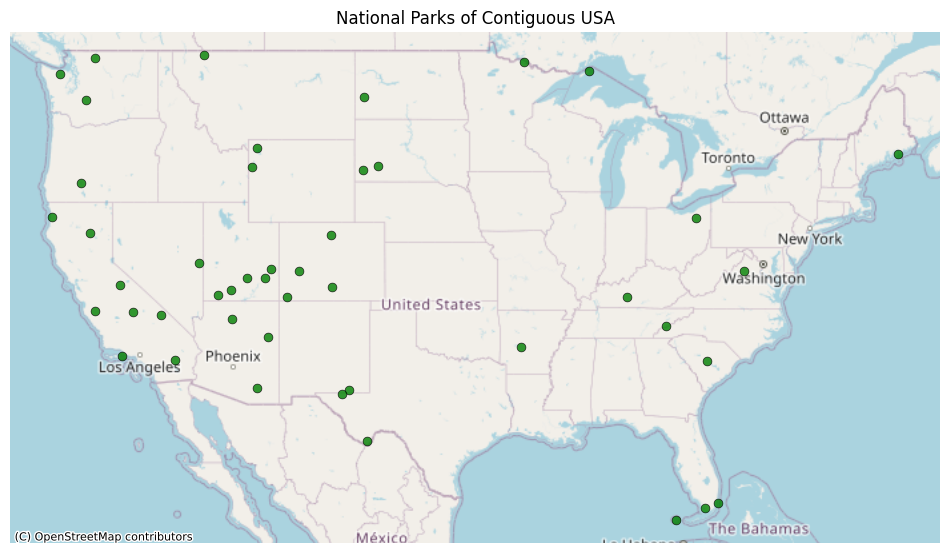

In [59]:
# Filter to exclude Alaska (AK) and Hawaii (HI)
geo_df_filtered = geo_df_points[~geo_df_points['state'].isin(['AK', 'HI'])]

# Check and set CRS to EPSG:4326 if necessary (WGS 84 - latitude/longitude)
if geo_df_filtered.crs is None or geo_df_filtered.crs.to_string() != 'EPSG:4326':
    geo_df_filtered = geo_df_filtered.set_crs(epsg=4326)

# Convert to Web Mercator (EPSG:3857) for basemap compatibility
geo_df_filtered = geo_df_filtered.to_crs(epsg=3857)


# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 10))

# Plot points with smaller size and enhanced visibility
geo_df_filtered.plot(
    ax=ax, 
    markersize=40,  # Adjust point size as needed
    color='green',   # Set a bright color for the points
    edgecolor='black',  # Outline color for contrast
    linewidth=0.5,  # Outline width
    alpha=0.8       # Slight transparency
)

# Add a basemap from OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and axis off for better visualization
ax.set_title('National Parks of Contiguous USA')
ax.set_axis_off()

# Show the plot and save as image
plt.savefig("Images/USParksLatLong.png", bbox_inches='tight')
plt.show()

----
&nbsp;
#### Creating a POLYGON geometry GeoJSON file `parks_shapes.geojson`

In [60]:
merged_parks = pd.merge(df, geo_df, left_on='park_code', right_on='UNIT_CODE')
merged_parks = merged_parks.drop(columns=['acres', 'latitude', 'longitude', 'UNIT_CODE'])

print(f"Shape: {merged_parks.shape}")

Shape: (56, 5)


In [61]:
merged_geo_parks = gpd.GeoDataFrame(merged_parks, geometry=merged_parks['geometry'])
print(f"Type: {type(merged_geo_parks)}\nShape: {merged_geo_parks.shape}")

Type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (56, 5)


In [62]:
# Assert that there are no NaN values in merged_parks
assert not merged_geo_parks.isna().any().any(), "There are NaN values in merged_parks DataFrame"

In [63]:
# Export GeoDataFrame
merged_geo_parks.to_file("DATA/parks_shapes.geojson", driver="GeoJSON")

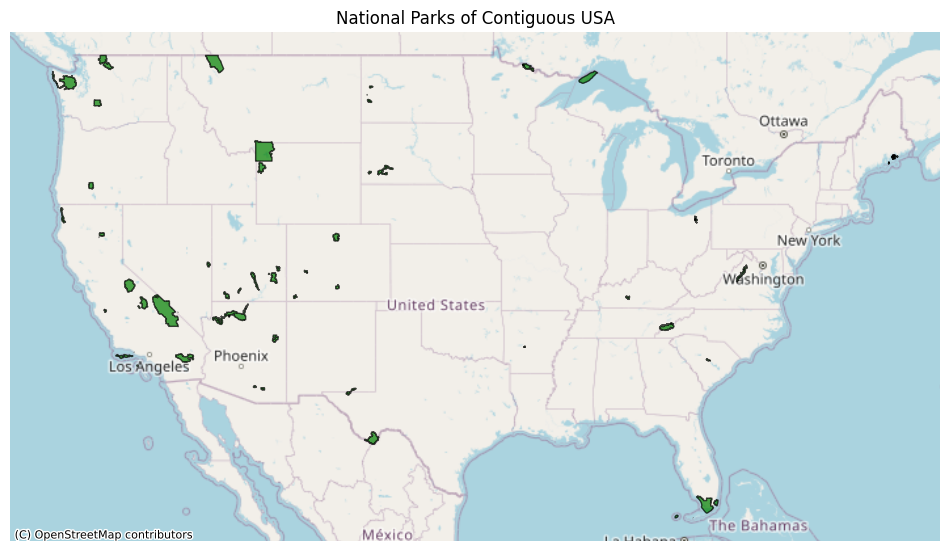

In [64]:
# Filter to exclude Alaska (AK) and Hawaii (HI)
merged_geo_parks_subset = merged_geo_parks[~merged_geo_parks['state'].isin(['AK', 'HI'])]

# Check and set CRS to EPSG:4326 if necessary (WGS 84 - latitude/longitude)
if merged_geo_parks_subset.crs is None or merged_geo_parks_subset.crs.to_string() != 'EPSG:4326':
    merged_geo_parks_subset = merged_geo_parks_subset.to_crs(epsg=4326)

# Convert to Web Mercator (EPSG:3857) for basemap compatibility
merged_geo_parks_subset = merged_geo_parks_subset.to_crs(epsg=3857)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 10))
merged_geo_parks_subset.plot(ax=ax, color='green', edgecolor='black', alpha=0.7)

# Add a basemap, from OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and axis off for better visualization
ax.set_title('National Parks of Contiguous USA')
ax.set_axis_off()

# Show the plot
plt.savefig("Images/USParksShapes.png", bbox_inches='tight')
plt.show()